<a href="https://colab.research.google.com/github/gverafei/artificial-networks-technologies/blob/main/tarea4/tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 4**
Oct 2025



## Instrucciones



### A. Configure virtual environment

Only execute these lines the first time. It will ask you to create a new virtual environment. In notebook, it might ask you to select a kernel from the upper right corner.

In [1]:
!python3 -m venv .venv

In [2]:
!source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

In [3]:
!pip install --upgrade pip --quiet

In [4]:
!pip install numpy --quiet

In [5]:
!pip install matplotlib --quiet

### 1. Programa para resolver el ejercicio de clase.

Tuve que hacer el programa porque en Excel era muy lenta la disminución del error cuadrático medio.

Aquí le puse un criterio de paro LMSE <= 0.0005 pero podríamos bajar más y queda aún más preciso.


In [80]:
import numpy as np

# =========================================================
# Activaciones y derivadas (usamos tanh en ocultas, sigmoide en salida)
# =========================================================
def sigmoid(u: float) -> float:
    return 1.0 / (1.0 + np.exp(-u))

def dsigmoid_from_y(y: float) -> float:
    # si y = sigmoid(u), entonces d/du = y*(1-y)
    return y * (1.0 - y)

def tanh_fn(a: float) -> float:
    return np.tanh(a)

def dtanh_from_h(h: float) -> float:
    # si h = tanh(a), entonces d/da = 1 - h^2
    return 1.0 - h**2

# =========================================================
# Forward de un patrón con pesos en diccionario (sin clases)
# =========================================================
def forward_once(x1: float, x2: float, y: float, W: dict,
                 hidden_act="tanh", out_act="sigmoid"):
    # Capa oculta
    z1 = W["w11"] * x1 + W["w12"] * x2 + W["b1"]
    z2 = W["w21"] * x1 + W["w22"] * x2 + W["b2"]
    if hidden_act == "tanh":
        h1 = tanh_fn(z1)
        h2 = tanh_fn(z2)
    else:
        raise ValueError("hidden_act debe ser 'tanh'.")

    # Capa de salida
    u = W["v1"] * h1 + W["v2"] * h2 + W["c"]
    if out_act == "sigmoid":
        y_hat = sigmoid(u)
    else:
        raise ValueError("out_act debe ser 'sigmoid'.")

    # Pérdida MSE por patrón
    L = 0.5 * (y_hat - y)**2

    return {
        "z1": z1, "z2": z2, "h1": h1, "h2": h2,
        "u": u, "y_hat": y_hat, "L": L
    }

# =========================================================
# Backprop + update (on-line) para un patrón
#   - Actualiza W in-place
# =========================================================
def backprop_update_once(x1: float, x2: float, y: float, W: dict, alpha: float,
                         hidden_act="tanh", out_act="sigmoid"):
    # Forward
    f = forward_once(x1, x2, y, W, hidden_act, out_act)
    h1, h2, y_hat = f["h1"], f["h2"], f["y_hat"]

    # Deltas
    if out_act == "sigmoid":
        delta_out = (y_hat - y) * dsigmoid_from_y(y_hat)
    else:
        raise ValueError("Solo se soporta sigmoide en la salida.")

    if hidden_act == "tanh":
        delta_h1  = dtanh_from_h(h1) * W["v1"] * delta_out
        delta_h2  = dtanh_from_h(h2) * W["v2"] * delta_out
    else:
        raise ValueError("Solo se soporta tanh en ocultas.")

    # Gradientes capa salida
    dL_dv1 = delta_out * h1
    dL_dv2 = delta_out * h2
    dL_dc  = delta_out

    # Gradientes capa oculta
    dL_dw11 = delta_h1 * x1
    dL_dw12 = delta_h1 * x2
    dL_db1  = delta_h1

    dL_dw21 = delta_h2 * x1
    dL_dw22 = delta_h2 * x2
    dL_db2  = delta_h2

    # Actualización (descenso de gradiente)
    W["v1"] -= alpha * dL_dv1
    W["v2"] -= alpha * dL_dv2
    W["c"]  -= alpha * dL_dc

    W["w11"] -= alpha * dL_dw11
    W["w12"] -= alpha * dL_dw12
    W["b1"]  -= alpha * dL_db1

    W["w21"] -= alpha * dL_dw21
    W["w22"] -= alpha * dL_dw22
    W["b2"]  -= alpha * dL_db2

    return f  # devuelve forward y deja W actualizado in-place

# =========================================================
# Entrenamiento on-line por épocas (orden configurable)
# =========================================================
def train_xor_online(
    alpha=0.1,
    max_epochs=100,
    init_weights=None,
    order=None,                 # lista de índices de patrones (0..3) en el orden deseado
    hidden_act="tanh",
    out_act="sigmoid",
    verbose=True,
    log_first_epoch=True,
    eps=0.05,    # criterio de paro (LMSE <= eps)
):
    """
    Entrena XOR (2-2-1) con backprop y MSE.
    - Actualización on-line por patrón (como tu Excel).
    - hidden_act='tanh', out_act='sigmoid'
    - Pesos iniciales en init_weights (dict); si None, usa tus iniciales del Excel.
    - order: orden de patrones (índices 0..3). Si None, usa [(0,1)->1, (1,0)->1, (0,0)->0, (1,1)->0].
    """
    # Datos XOR
    X = np.array([[0.0, 1.0],
                  [1.0, 0.0],
                  [0.0, 0.0],
                  [1.0, 1.0]], dtype=float)
    T = np.array([1.0, 1.0, 0.0, 0.0], dtype=float)

    if order is None:
        order = [0, 1, 2, 3]  # (0,1)->1 ; (1,0)->1 ; (0,0)->0 ; (1,1)->0

    # Pesos iniciales por defecto (idénticos a tu hoja)
    if init_weights is None:
        W = {
            "w11": 0.3,  "w12": -0.2, "b1": 0.0,
            "w21": 0.4,  "w22":  0.1, "b2": 2.0,
            "v1":  0.2,  "v2":  -0.3, "c":  0.1
        }
    else:
        # Creamos una copia para no mutar el dict de entrada
        W = {k: float(v) for k, v in init_weights.items()}

    hist = {"epoch": [], "lmse": []}

    for epoch in range(1, max_epochs + 1):
        Ls = []
        if verbose:
            print(f"\nEpoch {epoch:02d}  (alpha={alpha})")

        for ii, idx in enumerate(order, start=1):
            x1, x2 = X[idx]
            t      = T[idx]
            f = backprop_update_once(x1, x2, t, W, alpha, hidden_act, out_act)
            Ls.append(f["L"])

            if log_first_epoch and epoch == 1:
                print(f"  Pat {ii}: x=({int(x1)},{int(x2)}), t={int(t)} | "
                      f"z1={f['z1']:+.6f}, z2={f['z2']:+.6f}, "
                      f"h1={f['h1']:+.6f}, h2={f['h2']:+.6f}, "
                      f"u={f['u']:+.6f}, y_hat={f['y_hat']:.6f}, L={f['L']:.6f}")

        lmse = float(np.mean(Ls))
        hist["epoch"].append(epoch)
        hist["lmse"].append(lmse)

        if verbose:
            print(f"  LMSE (promedio época) = {lmse:.6f}")

        if lmse <= eps:
            if verbose:
                print(f"\nLMSE promedio {lmse:.6f} ≤ {eps} en la época {epoch}.")
            return W, hist

    if verbose:
        print("\nSe alcanzó max_epochs sin cumplir el criterio de paro.")
    return W, hist

# =========================================================
# Utilidades de evaluación
# =========================================================
def evaluate_xor(W: dict, thresh=0.5, hidden_act="tanh", out_act="sigmoid"):
    X = np.array([[0.0, 1.0],
                  [1.0, 0.0],
                  [0.0, 0.0],
                  [1.0, 1.0]], dtype=float)
    T = np.array([1.0, 1.0, 0.0, 0.0], dtype=float)
    yhat = []

    for (x1, x2), t in zip(X, T):
        f = forward_once(x1, x2, t, W, hidden_act, out_act)
        yhat.append(f["y_hat"])
    yhat = np.array(yhat)

    ybin = (yhat >= thresh).astype(int)
    acc = np.mean(ybin == T)
    return yhat, ybin, acc

# =========================================================
# Ejemplo de uso (se pueden cambiar hiperparámetros aquí)
# =========================================================
if __name__ == "__main__":
    hparams = {
        "alpha": 0.1,         # tasa de aprendizaje
        "max_epochs": 500000,      # número de épocas
        "hidden_act": "tanh", # activación oculta
        "out_act": "sigmoid", # activación de salida
        "order": [0, 1, 2, 3] # orden de patrones (coincide con tu Excel)
    }

    init_W = {
        "w11": 0.3,  "w12": -0.2, "b1": 0.0,
        "w21": 0.4,  "w22":  0.1, "b2": 2.0,
        "v1":  0.2,  "v2":  -0.3, "c":  0.1
    }

    W_tr, hist = train_xor_online(
        alpha=hparams["alpha"],
        max_epochs=hparams["max_epochs"],
        init_weights=init_W,
        order=hparams["order"],
        hidden_act=hparams["hidden_act"],
        out_act=hparams["out_act"],
        verbose=True,
        log_first_epoch=True,
        eps=0.0005    # criterio de paro (LMSE <= eps
    )

    print("\nPesos finales:")
    print({k: f"{v:.6f}" for k, v in W_tr.items()})

    yhat, ybin, acc = evaluate_xor(W_tr, thresh=0.5,
                                   hidden_act=hparams["hidden_act"],
                                   out_act=hparams["out_act"])

    print("\nSalidas finales (y_hat) por patrón:")
    X_list = [(0,1),(1,0),(0,0),(1,1)]
    T_list = [1,1,0,0]
    for i, ((x1,x2), t, yh, yb) in enumerate(zip(X_list, T_list, yhat, ybin), start=1):
        print(f"  Pat {i}: x=({x1},{x2}) | t={t} | y_hat={yh:.6f} | y_bin={yb}")

    print(f"\nExactitud binaria (umbral=0.5): {acc*100:.2f}%")



Epoch 01  (alpha=0.1)
  Pat 1: x=(0,1), t=1 | z1=-0.200000, z2=+2.100000, h1=-0.197375, h2=+0.970452, u=-0.230611, y_hat=0.442601, L=0.155347
  Pat 2: x=(1,0), t=1 | z1=+0.302643, z2=+2.399760, h1=+0.293730, h2=+0.983667, u=-0.110273, y_hat=0.472460, L=0.139149
  Pat 3: x=(0,0), t=0 | z1=+0.005013, z2=+1.999638, h1=+0.005013, h2=+0.964002, u=-0.135960, y_hat=0.466062, L=0.108607
  Pat 4: x=(1,1), t=0 | z1=+0.107694, z2=+2.499500, h1=+0.107279, h2=+0.986601, u=-0.144210, y_hat=0.464010, L=0.107653
  LMSE (promedio época) = 0.127689

Epoch 02  (alpha=0.1)
  LMSE (promedio época) = 0.127610

Epoch 03  (alpha=0.1)
  LMSE (promedio época) = 0.127538

Epoch 04  (alpha=0.1)
  LMSE (promedio época) = 0.127473

Epoch 05  (alpha=0.1)
  LMSE (promedio época) = 0.127412

Epoch 06  (alpha=0.1)
  LMSE (promedio época) = 0.127357

Epoch 07  (alpha=0.1)
  LMSE (promedio época) = 0.127306

Epoch 08  (alpha=0.1)
  LMSE (promedio época) = 0.127260

Epoch 09  (alpha=0.1)
  LMSE (promedio época) = 0.12721

### 2. Graficamos Epoca Vs LMSE

✅ Figura guardada en: figures/lmse_xor.png


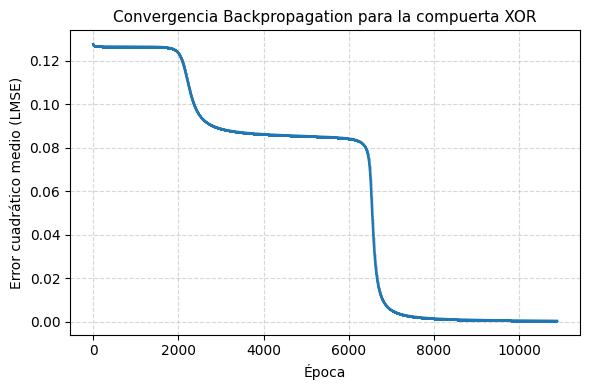

In [81]:
import matplotlib.pyplot as plt

def plot_lmse_vs_epoch(hist, save_path=None, title="Convergencia del algoritmo Backpropagation"):
    """
    Grafica LMSE (error cuadrático medio) por época.
    
    Parámetros:
    - hist: diccionario devuelto por train_xor_online()
    - save_path: ruta opcional para guardar la imagen (ej. 'lmse_xor.png')
    - title: título del gráfico
    """
    epochs = hist["epoch"]
    lmse = hist["lmse"]

    plt.figure(figsize=(6,4))
    plt.plot(epochs, lmse, marker='o', linewidth=1.8, markersize=0.1)
    plt.title(title, fontsize=11)
    plt.xlabel("Época", fontsize=10)
    plt.ylabel("Error cuadrático medio (LMSE)", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches="tight")
        print(f"✅ Figura guardada en: {save_path}")
    plt.show()

# Ejemplo de uso (tras entrenar)
plot_lmse_vs_epoch(hist, save_path="figures/lmse_xor.png",
                   title="Convergencia Backpropagation para la compuerta XOR")
